In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import sys 
sys.path.append("../..")
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union
from gpytorch.kernels import RBFKernel, MaternKernel
from multiscale_sde.util import softplus_inverse

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

manual_seed(0)
plt.style.use('seaborn-poster')
import seaborn as sns 

/tmp/ipykernel_862636/1254678545.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [36]:
# ts = np.concatenate(
#     [
#         np.random.uniform(low=0.1, high=0.5, size=5),
#         np.random.uniform(low=1.5, high=1.9, size=5)
#     ],
#     axis=0
# )
ts = np.linspace(0., 2., 100)
ts = np.sort(ts)
ts = torch.Tensor(ts).to(device)

In [37]:
method = "euler"
dt = 1e-3
adaptive = False
rtol = 1e-3
atol = 1e-3
adjoint = False
kl_anneal_iters = 100
dpi = 300
batch_size=512
sdeint_fn = torchsde.sdeint


In [58]:
class AgeHeartSDE(torchsde.SDEIto):

    def __init__(self, period=0.2, device="cpu"):
        super().__init__(noise_type="diagonal")
        self.device = device
        # let's do t\in [0, 2]
        self.period = period
        self.y0_mean = torch.Tensor([0, 0]).to(device) 
        self.y0_std = torch.Tensor([1, 1]).to(device) 
        

    def f(self, t, y):  # drift
        y_1 = y[:,:1]
        drift_1 = torch.ones(y_1.size(), device=self.device)
        drift_2 = y_1*10*torch.cos(2*np.pi * t / self.period)
        drift = torch.cat([drift_1, drift_2], axis=1)
        return drift
    
    def g(self, t, y):  # Diffusion.
        return torch.ones(y.size(), device=self.device)*0.01

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.y0_std) if eps is None else eps
        y0 = self.y0_mean + eps * self.y0_std
        ys = sdeint_fn(
            sde=self,
            y0=y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f', 'diffusion': 'g'}
        )
        return ys

In [59]:
dataSDE = AgeHeartSDE(period=0.1, device=device)

In [60]:
# ts.shape, y[:,0].repeat([1,2]).shape

In [61]:
# dataSDE.f(ts[:,None], y[:,0]).shape, dataSDE.g(ts[:,None], y[:,0]).shape

In [62]:
y = dataSDE.forward(ts[:,None], batch_size=5)

In [63]:
y_plot = y.cpu().detach().numpy()
ts_plot = ts.detach().cpu().numpy()

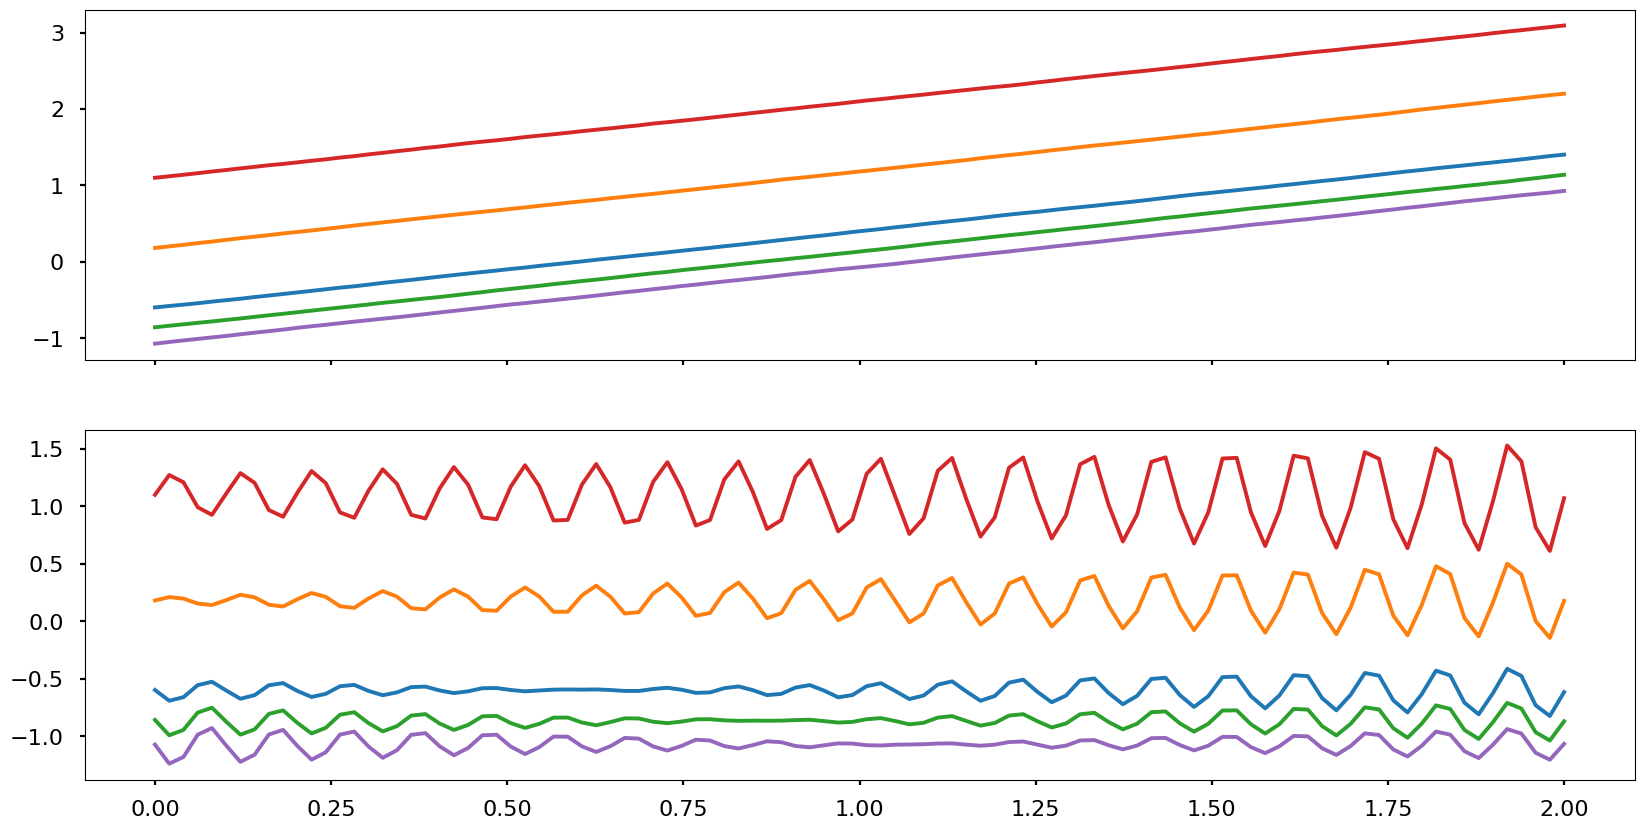

In [64]:
fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)
ax1.plot(ts_plot, y_plot[:,:,0])
ax2.plot(ts_plot, y_plot[:,:,1])